
### Part 1: Analyzing Best-Seller Trends Across Product Categories


**Objective**: Understand the relationship between product categories and their best-seller status.

1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    
    - Are there categories where being a best-seller is more prevalent? 
    	
    	*Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*

In [4]:
import pandas as pd
# Load the dataset
df = pd.read_csv('amz_uk_price_prediction_dataset.csv')
df.columns

Index(['uid', 'asin', 'title', 'stars', 'reviews', 'price', 'isBestSeller',
       'boughtInLastMonth', 'category'],
      dtype='object')

In [6]:
import pandas as pd

# Step 1: Create a crosstab between category and isBestSeller
crosstab = pd.crosstab(df['category'], df['isBestSeller'])

# Step 2: Calculate the proportion of best-sellers per category
crosstab['bestSellerRate'] = crosstab[True] / (crosstab[True] + crosstab[False])

# Step 3: Sort categories by best-seller rate in descending order
sorted_crosstab = crosstab.sort_values(by='bestSellerRate', ascending=False)

# Step 4: Display the result
print(sorted_crosstab[['bestSellerRate']])


isBestSeller                      bestSellerRate
category                                        
Grocery                                 0.058135
Smart Home Security & Lighting          0.057692
Health & Personal Care                  0.057686
Mobile Phone Accessories                0.042471
Power & Hand Tools                      0.035339
...                                          ...
CD, Disc & Tape Players                 0.000000
General Music-Making Accessories        0.000000
Snowboard Boots                         0.000000
Boxes & Organisers                      0.000000
eBook Readers & Accessories             0.000000

[296 rows x 1 columns]


Top Performing Categories:
Grocery (5.8%)
Smart Home Security & Lighting (5.77%)
Health & Personal Care (5.77%)

Underperforming Categories

These categories have a 0% best-seller rate:
CD, Disc & Tape Players
General Music-Making Accessories
Snowboard Boots
Boxes & Organisers
eBook Readers & Accessories

This could mean:
Low sales volume
Niche or outdated products
Poor visibility or marketing

2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.

In [7]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create contingency table
contingency_table = pd.crosstab(df['category'], df['isBestSeller'])

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display results
print(f"Chi-square statistic: {chi2:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p:.5f}")


Chi-square statistic: 36540.20
Degrees of freedom: 295
p-value: 0.00000


Chi-square statistic: 36,540.20
Degrees of freedom: 295
p-value: < 0.00001 (effectively zero)

Conclusion:

There is a very strong statistical association between product category and best-seller status. The likelihood that this relationship is due to random chance is virtually nonexistent.

In [8]:
import numpy as np

# Calculate Cramér's V
n = contingency_table.sum().sum()  # total number of observations
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print(f"Cramér's V: {cramers_v:.3f}")


Cramér's V: 0.122


This indicates a small but meaningful association between product category and best-seller status.

While the Chi-square test showed a statistically significant relationship, Cramér’s V tells us that the effect size is modest.

3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

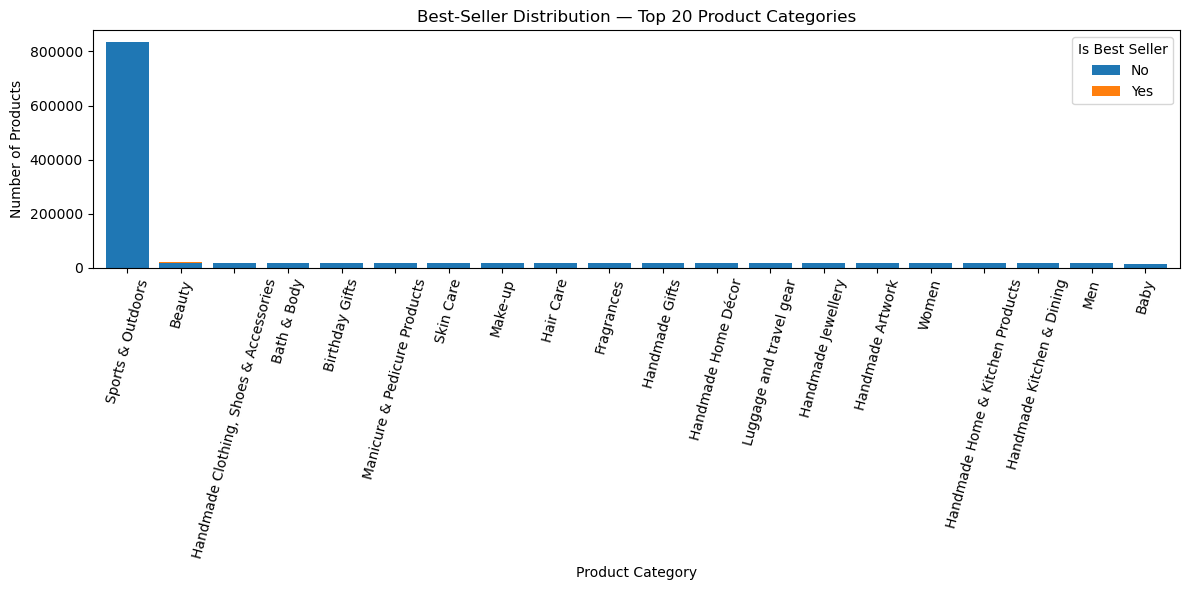

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Create crosstab
crosstab = pd.crosstab(df['category'], df['isBestSeller'])

# Step 2: Get top 20 categories by total product count
top_20_categories = crosstab.sum(axis=1).sort_values(ascending=False).head(20)

# Step 3: Filter crosstab to top 20
crosstab_top20 = crosstab.loc[top_20_categories.index]

# Step 4: Plot stacked bar chart
crosstab_top20.plot(kind='bar', stacked=True, figsize=(12, 6), width=0.8)

# Step 5: Customize chart
plt.title('Best-Seller Distribution — Top 20 Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.legend(title='Is Best Seller', labels=['No', 'Yes'])
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

**Objective**: Investigate how different product categories influence product prices.

0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*

In [11]:
# Step 1: Calculate Q1, Q3, and IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Step 2: Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Filter out outliers
df_no_outliers = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Step 4: Check shape before and after
print(f"Original dataset size: {df.shape[0]}")
print(f"Filtered dataset size: {df_no_outliers.shape[0]}")


Original dataset size: 2443651
Filtered dataset size: 2115963


1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.

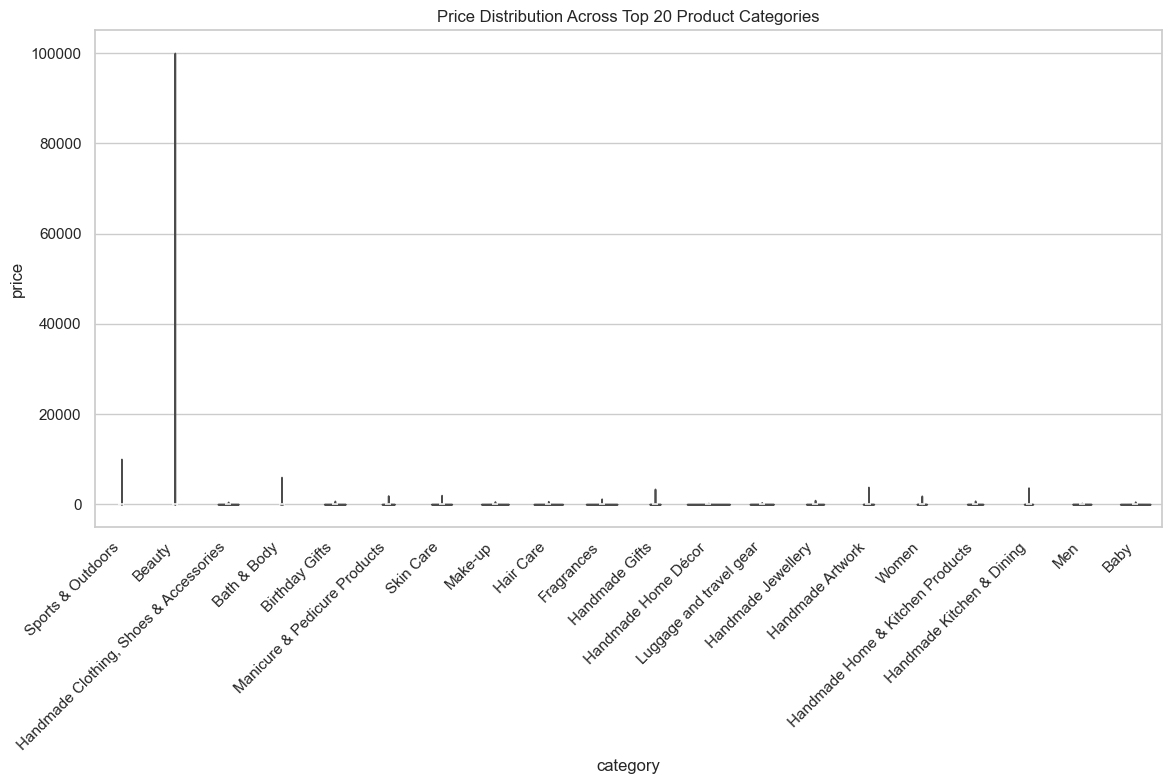

Category with highest median price: Laptops (£1042.72)


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('amz_uk_price_prediction_dataset.csv')

# Drop rows with missing values in relevant columns
df_clean = df.dropna(subset=['price', 'category'])

# Filter top 20 categories by count
top_categories = df_clean['category'].value_counts().nlargest(20).index
filtered_df = df_clean[df_clean['category'].isin(top_categories)]

# Set seaborn style
sns.set(style="whitegrid")

# Create violin plot
plt.figure(figsize=(12, 8))
violin_plot = sns.violinplot(x='category', y='price', data=filtered_df)
violin_plot.set_xticks(range(len(top_categories)))
violin_plot.set_xticklabels(top_categories, rotation=45, ha='right')
plt.title('Price Distribution Across Top 20 Product Categories')
plt.tight_layout()
plt.show()

# Identify category with highest median price (without filtering)
median_prices = df_clean.groupby('category')['price'].median()
highest_median_category = median_prices.idxmax()
highest_median_value = median_prices.max()

print(f"Category with highest median price: {highest_median_category} (£{highest_median_value:.2f})")


2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.

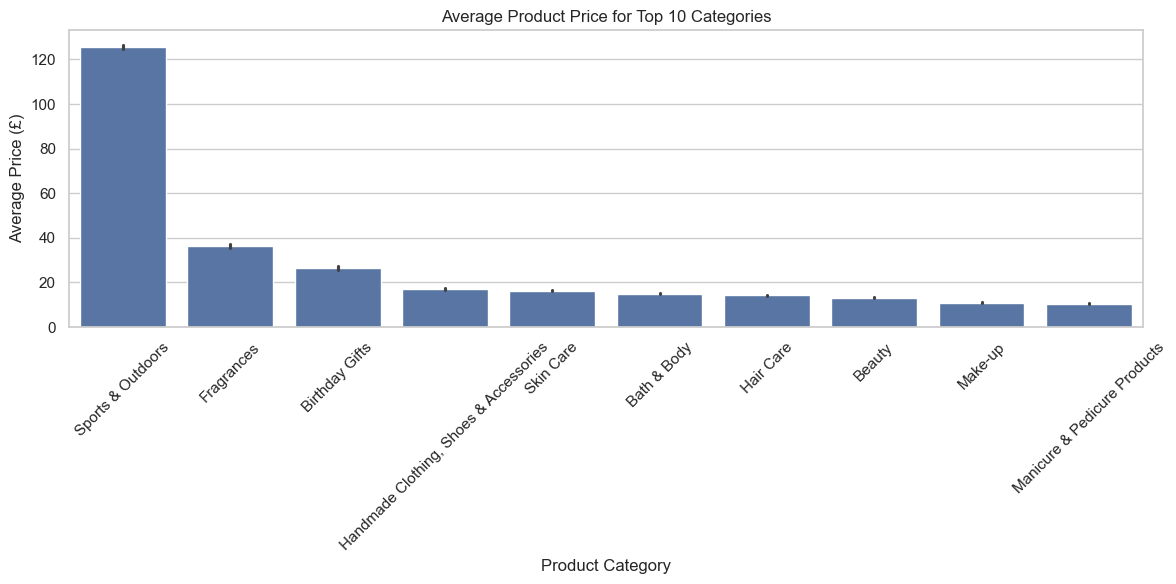

Category with highest average price overall: Laptops (£1087.99)


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('amz_uk_price_prediction_dataset.csv')

# Drop rows with missing or non-numeric prices
df_clean = df.dropna(subset=['price', 'category'])
df_clean['price'] = pd.to_numeric(df_clean['price'], errors='coerce')
df_clean = df_clean.dropna(subset=['price'])

# Top 10 categories by count
top_10_categories = df_clean['category'].value_counts().nlargest(10).index
top_df = df_clean[df_clean['category'].isin(top_10_categories)]

# Average price per top category
avg_price_top = top_df.groupby('category')['price'].mean().sort_values(ascending=False)

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='category', y='price', data=top_df, order=avg_price_top.index)
plt.title('Average Product Price for Top 10 Categories')
plt.xlabel('Product Category')
plt.ylabel('Average Price (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identify category with highest average price overall
avg_price_all = df_clean.groupby('category')['price'].mean()
highest_avg_category = avg_price_all.idxmax()
highest_avg_value = avg_price_all.max()

print(f"Category with highest average price overall: {highest_avg_category} (£{highest_avg_value:.2f})")


3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

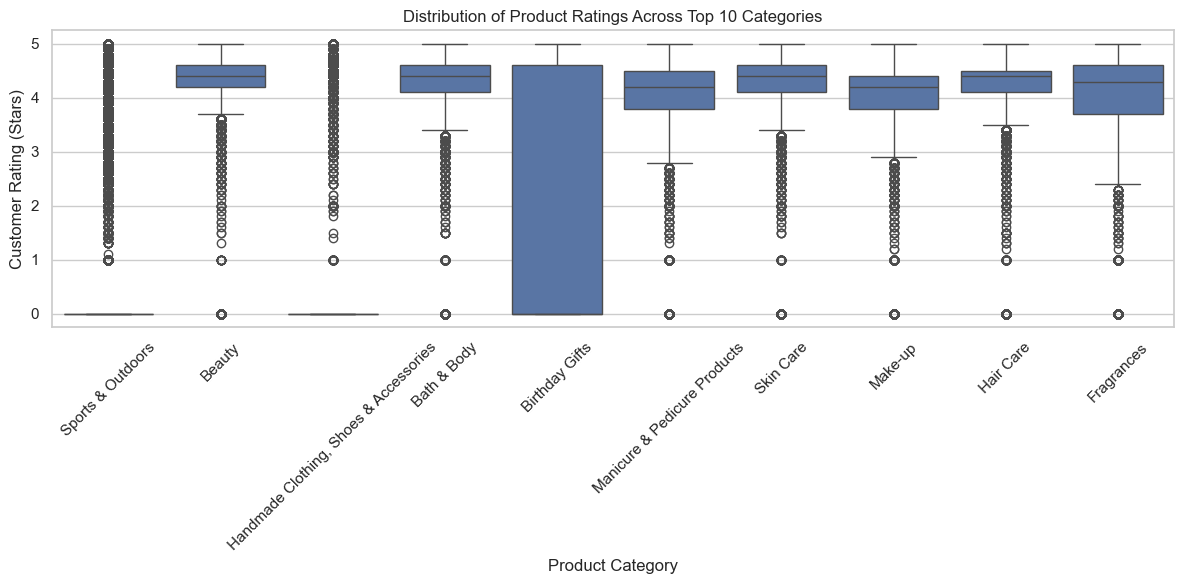

Category with highest median rating: Computer Memory (4.70 stars)


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('amz_uk_price_prediction_dataset.csv')

# Drop rows with missing or non-numeric ratings
df_clean = df.dropna(subset=['stars', 'category'])
df_clean['stars'] = pd.to_numeric(df_clean['stars'], errors='coerce')
df_clean = df_clean.dropna(subset=['stars'])

# Top 10 categories by count
top_10_categories = df_clean['category'].value_counts().nlargest(10).index
top_df = df_clean[df_clean['category'].isin(top_10_categories)]

# Plot box plots
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='stars', data=top_df, order=top_10_categories)
plt.title('Distribution of Product Ratings Across Top 10 Categories')
plt.xlabel('Product Category')
plt.ylabel('Customer Rating (Stars)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identify category with highest median rating (across all categories)
median_ratings = df_clean.groupby('category')['stars'].median()
highest_median_category = median_ratings.idxmax()
highest_median_value = median_ratings.max()

print(f"Category with highest median rating: {highest_median_category} ({highest_median_value:.2f} stars)")


### Part 3: Investigating the Interplay Between Product Prices and Ratings

**Objective**: Analyze how product ratings (`stars`) correlate with product prices.

1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?

In [19]:
import pandas as pd
from scipy.stats import pearsonr

# Load your dataset
df = pd.read_csv('amz_uk_price_prediction_dataset.csv')

# Clean data: drop missing or non-numeric values
df_clean = df.dropna(subset=['price', 'stars'])
df_clean['price'] = pd.to_numeric(df_clean['price'], errors='coerce')
df_clean['stars'] = pd.to_numeric(df_clean['stars'], errors='coerce')
df_clean = df_clean.dropna(subset=['price', 'stars'])

# Calculate Pearson correlation coefficient
correlation, p_value = pearsonr(df_clean['price'], df_clean['stars'])

# Display results
print(f"Pearson correlation coefficient between price and stars: {correlation:.4f}")
print(f"P-value: {p_value:.4e}")

# Interpretation
if p_value < 0.05:
    print("✅ Statistically significant correlation between price and rating.")
else:
    print("❌ No statistically significant correlation between price and rating.")


Pearson correlation coefficient between price and stars: -0.1249
P-value: 0.0000e+00
✅ Statistically significant correlation between price and rating.


Correlation Coefficient: −0.1249
This is a weak negative correlation, meaning that as product ratings (stars) increase, prices tend to decrease slightly.
However, the relationship is not strong—ratings explain only a small portion of the variation in price.
P-value: 0.0000

This indicates the correlation is statistically significant we can be confident that the observed relationship isn’t due to random chance.

What This Might Mean
Higher-rated products might be more competitively priced to attract buyers.
Alternatively, cheaper products might receive higher ratings due to perceived value.
Or it could reflect category-specific trends—for example, budget electronics often get high ratings relative to their price.


2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between all numerical variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot. 

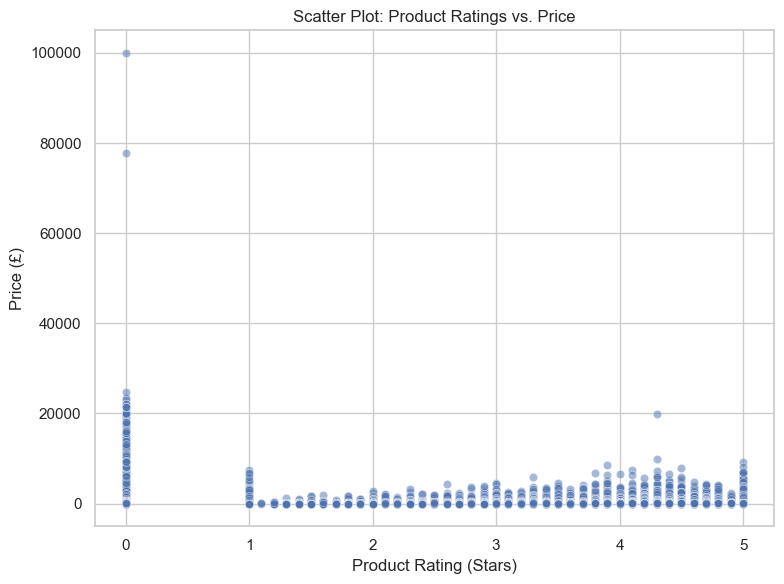

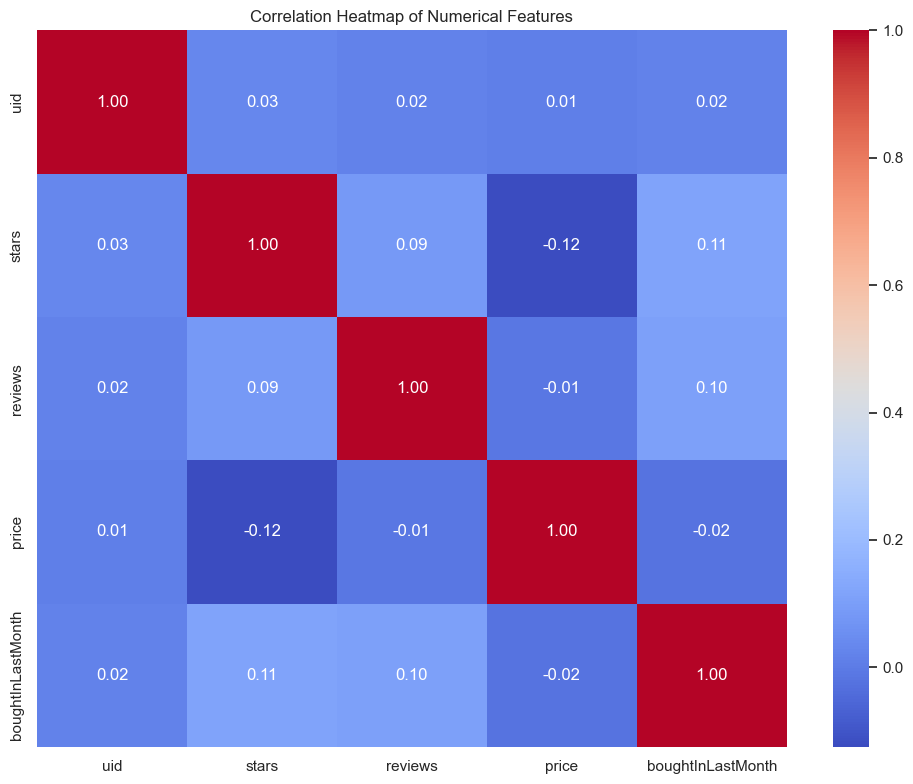

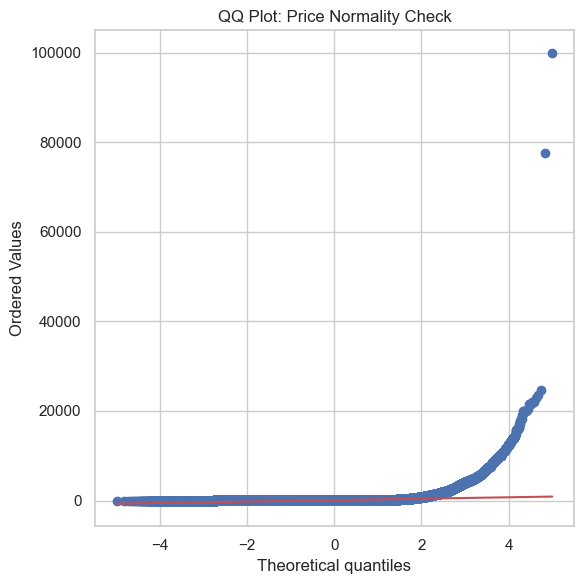

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Load dataset
df = pd.read_csv('amz_uk_price_prediction_dataset.csv')

# Clean data: ensure numeric types and drop missing values
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['stars'] = pd.to_numeric(df['stars'], errors='coerce')
df_clean = df.dropna(subset=['price', 'stars'])

# 1. Scatter Plot: Ratings vs. Price
plt.figure(figsize=(8, 6))
sns.scatterplot(x='stars', y='price', data=df_clean, alpha=0.5)
plt.title('Scatter Plot: Product Ratings vs. Price')
plt.xlabel('Product Rating (Stars)')
plt.ylabel('Price (£)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Correlation Heatmap
plt.figure(figsize=(10, 8))
numeric_df = df_clean.select_dtypes(include='number')
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

# 3. QQ Plot: Price Distribution
plt.figure(figsize=(6, 6))
stats.probplot(df_clean['price'], dist="norm", plot=plt)
plt.title('QQ Plot: Price Normality Check')
plt.tight_layout()
plt.show()


Scatter plot:
General Distribution
Dense cluster of products priced below £20,000, especially under £10,000, regardless of rating.
Ratings between 3 and 5 stars dominate the dataset—suggesting most products are well-reviewed.

Outliers
A few products with 0-star ratings are priced extremely high, even up to £100,000.
These could be anomalies, luxury items, or data entry errors.
Worth investigating: Are these missing ratings or actual poor reviews?

Trend Insight
No strong upward or downward trend is visible—supporting the weak negative correlation coefficient (−0.1249).
Suggests that price doesn’t strongly influence rating, or vice versa.

This could indicate that:
High-priced items may not always be highly rated—consumers could be more critical of expensive purchases.
Mid-range products (under £10,000) tend to receive better ratings, possibly reflecting good value for money.
Low-rated expensive products might be niche, poorly received, or suffer from unmet expectations


1. Correlation Analysis
Pearson correlation coefficient between price and stars: −0.1249
P-value: 0.0000 → statistically significant
Interpretation: Weak negative correlation—higher-rated products tend to be slightly cheaper.

2. Scatter Plot Insights
Most products are priced below £20,000, especially those rated between 1 and 5 stars.
Products with 0-star ratings show a wide price range, including extreme outliers up to £100,000.
No strong trend observed, supporting the weak correlation.

3. Correlation Heatmap Highlights
Feature Pair	Correlation	Insight
stars vs. price	−0.12	Higher-rated products are slightly cheaper.
stars vs. boughtInLastMonth	0.11	Better-rated products are bought more often.
reviews vs. boughtInLastMonth	0.10	Popular products (more reviews) drive purchases.
price vs. boughtInLastMonth	−0.02	Price has minimal impact on purchase frequency.

4. QQ Plot Findings
Price data does not follow a normal distribution.
Significant deviation from the normal line, especially in the upper tail.
Indicates right-skewed distribution with heavy outliers.

Conclusion
Product ratings and reviews are more influential than price in driving purchases.
Price is relatively isolated and skewed, requiring careful handling in modeling.
Further analysis by product category or using log-transformed price could reveal deeper insights.